## Smartbeat feature classification based on smartphone data

Activity Recognition using Cell Phone Accelerometers
Jennifer R. Kwapisz, Gary M. Weiss, Samuel A. Moore 

Data: http://www.cis.fordham.edu/wisdm/

### Data

Based on smartphone data. 
acc. data every 50ms. 20 samples/second.


### Intro

### features

### Preprocessing of data. 

Starting from raw data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#header for the raw data: 
rawhead = ["user","activity","timestamp","x-acceleration","y-accel","z-accel"]

In [3]:
#activity list
act = ["Walking","Jogging","Sitting","Standing","Upstairs","Downstairs"] 

In [4]:
datpath ="/home/ubuntu/Smartbeat/digi-act-track/data/WISDM_ar_v1.1_raw.txt"

In [5]:
#import pandas dataframe
df = pd.read_csv('data/WISDM_ar_v1.1_raw.txt', header=None, names=['user', 'label', 'timestamp', 'x', 'y', 'z'], comment=';')
#sort the dataframe according to timestamp.
df = df.sort_values('timestamp')
#print information about the dataframe
df.info()
df.index

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098204 entries, 882376 to 1052820
Data columns (total 6 columns):
user         1098204 non-null int64
label        1098204 non-null object
timestamp    1098204 non-null int64
x            1098204 non-null float64
y            1098204 non-null float64
z            1098204 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB


Int64Index([ 882376,  164943,  165014,  165015,  165027,  165028,  165029,
             165061,  165062,  165074,
            ...
            1052811, 1052812, 1052813, 1052814, 1052815, 1052816, 1052817,
            1052818, 1052819, 1052820],
           dtype='int64', length=1098204)

In [6]:
# The sampling rate to use
SAMPLING_RATE = 20.0

# Window length to use for classification (Samples @ 10 Hz)
WINDOW_LENGTH = 100 

# Stride length to use between windows (decrease to increase dataset size)
WINDOW_STRIDE = WINDOW_LENGTH * 1

# Mapping from label index to label name. 
IDX_TO_LABELS = df.label.unique()

# Mapping from label name to label index. Dict mapping labels : index
LABELS_TO_IDX = {label:idx for idx, label in enumerate(IDX_TO_LABELS)}

In [7]:
#create dataframes of length windowsize
import numpy as np
from utils import sliding_window, split_user_df
from preprocessing import *

In [8]:
import numpy as np
from utils import sliding_window, split_user_df
from preprocessing import resample_df

# Split the label DataFrame per user
# Group dataframe by user and label. This will provide a df for every seperate activity for every single user.
# Creates an iterable groupby element. 
df_grouped = df.groupby(('label', 'user'))

#initialization of lists.
wdws = [] #List of df signal windows
y = [] #list encoded label for window corresponding to wdws list
ids = [] #list of user ID for window corresponding to wdws list

# Iterate over all keys in df_grouped, store window dataframe in wdws, store label in y, store user id in ids. 

for (label,user), wdw in df_grouped:
    
    #Split wdw up in sub_wdws for different recording sessions assuming they differ when time jumps more than 1 second. 
    sub_wdws = split_user_df(wdw)
    
    # Throw away sub_wdws < 10s, resample, calculate sliding windows. 
    for sub_wdw in sub_wdws:
    
        #calculate the relative time of the dataframe in seconds (relative to the start of that dataframe.)
        ts = (sub_wdw.timestamp-sub_wdw.timestamp.iloc[0])/1e9


        #omit any dataframes that are less than 10s
        if ts.iloc[-1] < 10:
            continue
        
        # Resample the dataframe to a dataframe with SAMPLING_RATE
        sub_wdw = resample_df(sub_wdw,SAMPLING_RATE)
        
        # Apply sliding window with window Length = (,)
        i= 0 #beginning index of each new window. 
        a= 0
        b= 0
        while i < (len(sub_wdw)-WINDOW_LENGTH):
            a= i
            b = i + WINDOW_LENGTH
            #print('wdw length : ' + str(len(sub_wdw)))
            #print(str(i) + ' | a:' + str(a) +' | b:' + str(b))
            sliced_wdw = sub_wdw.iloc[a:b] # cut a window slice of length "WINDOW_LENGTH" from this subframe. 
            wdws.append(sliced_wdw) # append sliced window to the global wdws list. 
            
            # the following line uses the same 'user' and 'label' for every sliced window in this isntance of the loop. 
            ids.append(user) # append user id corresponding to this sliced window
            y.append(LABELS_TO_IDX[label]) # append user id corresponding to this sliced window. 
            
            #increment the counter
            i = i + WINDOW_LENGTH
        
            

print('there are ' + str(len(df_grouped)) + ' groups in df_grouped')
print('there are ' + str(len(wdws)) + ' windows in wdws')
print('there are ' + str(len(y)) + ' labels in y')
print('there are ' + str(len(ids)) + ' user-ids in ids')

    

ValueError: Digital filter critical frequencies must be 0 < Wn < 1

#save y to harddrive. 
y= pd.DataFrame(y)
y.to_csv('y.csv',index = False)

In [45]:
#save the id's
ids = pd.DataFrame(ids)
ids.to_csv('ids.csv',index = False)

31

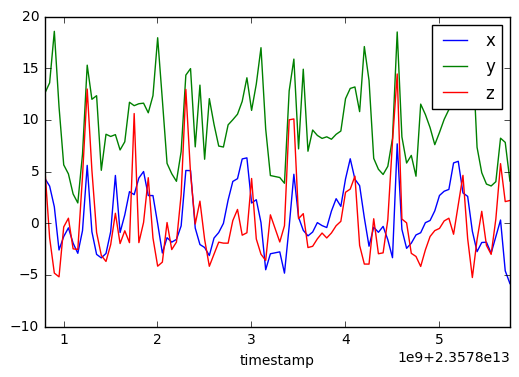

In [9]:
#plotting a random sample and label. 
i= 10000
wdws[i].plot('timestamp')
IDX_TO_LABELS[y[i]]
ids[i]

### calculate features.

We will apply a forward feature selection process. This means that we start with a limited set of features and make a prediction. We note the accuracy that is obtained. 

After this, we add a feature and repeat the assesment of the accuracy. The feature is selected based on it's contribution to an increasing accuracy. We repeat this process untill the desired accuracy is obtained. 

Forward feature selection is the opposite of backward feature selection where you start with a lot of features and drop them iteratevly en select by assesing the decline of the accuracy. 

### Average (for each axis)

The average over each axis is calculated. (No normalization is performed) 

In [10]:
#create mean for each window and put in list temp_mean_list
temp_mean_list =[(wdws[i].x.mean(),wdws[i].y.mean(),wdws[i].z.mean()) for i in range(0,len(wdws))]
#convert temp_mean_list to dataframe mean_df
mean_df = pd.DataFrame(data=temp_mean_list, columns = ['av_x','av_y','av_z'])

In [11]:
mean_df.head()

,av_x,av_y,av_z
0,-1.947567,9.833762,1.960378
1,-6.990994,7.945942,0.690731
2,-8.802782,5.551300,0.845816
3,-8.818716,5.741674,1.019364
4,-9.068934,5.703533,0.866024


In [3]:
#concatenate mean_df to feat_df
feat_df = mean_df #later reference: result = pd.concat([df1, df4], axis=1)

NameError: name 'mean_df' is not defined

### Std Deviation

In [13]:
temp_stdev_list = [(wdws[i].x.std(),wdws[i].y.std(),wdws[i].z.std()) for i in range(0,len(wdws))]

In [14]:
stdev_df = pd.DataFrame(data = temp_stdev_list, columns = ['stdev_x','stdev_y','stdev_z'])

In [15]:
#concatenate mean_df to feat_df
feat_df = pd.concat([feat_df, stdev_df], axis=1)

### Average absolute difference = mean absolute deveation

Average absolute difference between the value of each of the 200 readings within the ED and the mean value over those 200 values(for each axis).

In [16]:
temp_mad_list = [(wdws[i].x.mad(),wdws[i].y.mad(),wdws[i].z.mad()) for i in range(0,len(wdws))]

In [17]:
mad_df = pd.DataFrame(data = temp_mad_list, columns = ['mad_x','mad_y','mad_z'])

In [18]:
#concatenate mean_df to feat_df
feat_df = pd.concat([feat_df,mad_df], axis=1)

In [19]:
feat_df.head()

,av_x,av_y,av_z,stdev_x,stdev_y,stdev_z,mad_x,mad_y,mad_z
0,-1.947567,9.833762,1.960378,3.292994,4.189694,4.214619,2.637472,3.412507,3.331594
1,-6.990994,7.945942,0.690731,4.333977,4.048604,3.088699,3.599914,3.398023,2.415842
2,-8.802782,5.551300,0.845816,4.266730,4.511960,2.908426,3.481611,3.828914,2.400074
3,-8.818716,5.741674,1.019364,4.145614,4.162139,2.680245,3.347830,3.500669,2.203985
4,-9.068934,5.703533,0.866024,4.793156,4.370510,3.262572,3.694098,3.576835,2.533819


### Average Resultant Acceleration

In [20]:
#list of average resultant acceleration
temp_ara_list = [wdws[i].apply(lambda x: np.sqrt(x.dot(x)), axis = 1).mean() for i in range(0,len(wdws))]

In [21]:
ara_df = pd.DataFrame(data = temp_ara_list, columns = ['ara'])

In [22]:
#concatenate mean_df to feat_df
feat_df = pd.concat([feat_df,ara_df], axis=1)

In [23]:
feat_df.head()

,av_x,av_y,av_z,stdev_x,stdev_y,stdev_z,mad_x,mad_y,mad_z,ara
0,-1.947567,9.833762,1.960378,3.292994,4.189694,4.214619,2.637472,3.412507,3.331594,6.555417e+12
1,-6.990994,7.945942,0.690731,4.333977,4.048604,3.088699,3.599914,3.398023,2.415842,6.560417e+12
2,-8.802782,5.551300,0.845816,4.266730,4.511960,2.908426,3.481611,3.828914,2.400074,6.565417e+12
3,-8.818716,5.741674,1.019364,4.145614,4.162139,2.680245,3.347830,3.500669,2.203985,6.570417e+12
4,-9.068934,5.703533,0.866024,4.793156,4.370510,3.262572,3.694098,3.576835,2.533819,6.575417e+12


### Time between peaks

Time in milliseconds between peaks in the sinusoidal waves associated with most
activities. (for each axis) 

The repetitive activities, like walking, tend to generate repeating
waves for each axis and this feature tries to measure the time
between successive peaks. To estimate this value, for each
example we first identify all of the peaks in the wave using a
heuristic method and then identify the highest peak for each axis.
We then set a threshold based on a percentage of this value and
find the other peaks that met or exceed this threshold; if no peaks
meet this criterion then the threshold is lowered until we find at
least three peaks. We then measure the time between successive
peaks and calculate the average. For samples where at least three
peaks could not be found, the time between peaks is marked as
unknown. This method was able to accurately find the time
between peaks for the activities that had a clear repetitive pattern,
like walking and jogging. Certainly more sophisticated schemes
will be tried in the future. 

Using a peak detection package: http://nbviewer.jupyter.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

In [2]:
from detect_peaks import detect_peaks


In [206]:
#method to find minimum 3 top peaks and return mean time difference
def mean_time_between_peaks(data,timestamps, min_num_peaks):
    #set new local index starting from 0 to len(data)
    local_index = range(0,len(data))
    data.index = local_index
    timestamps.index = local_index
    
    #determine indices of all local peaks
    peak_index = detect_peaks(data)
    #determine the peak with max value
    peak_max = data[peak_index].max()
    #search for factor that results in minimally 3 peaks
    for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        #recalculate peaks with maximum peak height limited. 
        peak_index = detect_peaks(data, mph = peak_max-peak_max*i)
        
        if len(peak_index) < min_num_peaks:
            continue
        if len(peak_index) >= min_num_peaks:
            break #stop when enough peaks are present. 
    if len(peak_index) != 0:
        #calculate peak values & timestamps 
        peak_values = data[peak_index]
        peak_timestamps = timestamps[peak_index]
        #calculate time difference between peaks
        time_differences = np.diff(peak_timestamps,n=1)
        #calculate the mean difference between peaks
        mean_time_between_peaks = time_differences.mean()
    else:
        mean_time_between_peaks = None
    return mean_time_between_peaks

In [208]:
#create a list with mtbp for 3 axis for every window in wdws
temp_tbp_list =[(mean_time_between_peaks(wdws[i].x,wdws[i].timestamp, 3),mean_time_between_peaks(wdws[i].y,wdws[i].timestamp, 3),mean_time_between_peaks(wdws[i].z,wdws[i].timestamp, 3)) for i in range(0,len(wdws))]

In [209]:
tbp_df = pd.DataFrame(temp_tbp_list, columns= ['tbp_x','tbp_y','tbp_z'])

In [215]:
#concatenate mean_df to feat_df
feat_df = pd.concat([feat_df,tbp_df], axis=1)

### save and load files

In [233]:
#feat_df.to_csv('data_after_tbp.csv',index = False)

In [5]:
feat_df = pd.read_csv('data_after_tbp.csv')

In [6]:
IDX_TO_LABELS = pd.read_csv('IDX_TO_LABELS.csv').as_matrix()

## Training random tree forest.

### Preparing feature dataframe for training

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = feat_df.fillna(0) #load feature data and convert NaN to 0

In [9]:
X = X.as_matrix() #convert to numpy array

In [10]:
y = pd.read_csv('y.csv') #load label data

In [11]:
y = y.as_matrix() #convert to numpy array

In [14]:
X_train,X_test, y_train,y_test = train_test_split(X, y, test_size = 0.3, shuffle=True) #split into train and test set. 

### training & prediction

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, linear_model


In [16]:
# create and compile the model
forest = RandomForestClassifier(criterion='entropy',n_estimators=40)

In [17]:
#fit the training data
forest.fit(X_train,y_train)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
y_test_pred = forest.predict(X_test)

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
#cm = np.zeros([len(LABELS_TO_IDX), len(LABELS_TO_IDX)])
cm = confusion_matrix(y_test, y_test_pred)

In [21]:
np_confusion = confusion_matrix(y_test, y_test_pred)
pd_confusion = pd.DataFrame(np_confusion, index= IDX_TO_LABELS,columns=IDX_TO_LABELS)
pd_confusion

,"(Walking,)","(Jogging,)","(Upstairs,)","(Downstairs,)","(Standing,)","(Sitting,)"
"(Walking,)",1212,1,8,5,0,0
"(Jogging,)",7,993,0,0,0,0
"(Upstairs,)",38,17,270,21,1,0
"(Downstairs,)",47,4,21,212,2,0
"(Standing,)",0,0,0,0,146,1
"(Sitting,)",0,0,1,0,3,170


In [22]:
from sklearn.metrics import accuracy_score

In [23]:
'The normalized accuracy is :' + str(accuracy_score(y_true = y_test, y_pred = y_test_pred,normalize = True ))

'The normalized accuracy is :0.944339622642'

Conclusions: 
It was found that randomizing the input data was abolsutely critical to obtaining areasonable result when using random forest trees.Therefore the data was randomized and and split into a training and testing dataset. 

The results is too optimistic because the training was done on all training data, meaning all users. Therefore we need to split the data per user and train and evalute the model on segregated data based on users. 

Another option would be tocreate a sytem that needs to be calibrated by the user. 

### split by user

In [25]:
# What number of users are there. 

In [12]:
ids = pd.read_csv('ids.csv') # load ids 

In [13]:
'There are ' + str(len(ids.iloc[:,0].unique())) + ' unique users. Starting at 1 and last value 36.'

'There are 36 unique users. Starting at 1 and last value 36.'

We want to exclude 2 users from the selection.

In [1]:
#Load data
#y
y = pd.read_csv('y.csv') #load label data
y = y.as_matrix() #convert to numpy array

#X
feat_df = pd.read_csv('data_after_tbp.csv')
X = feat_df.fillna(0) #load feature data and convert NaN to 0
X = X.as_matrix() #convert to numpy array

#id's
ids = pd.read_csv('ids.csv') # load ids 
ids= ids.as_matrix()

NameError: name 'pd' is not defined

We will use X, y and ids to perform a K-fold group split. Every group corresponds to 1 specific user. 

In [28]:
from sklearn.model_selection import GroupKFold
def fold_gen_method(): #This method generates an iterator/generator that returns 1 fold every time in the form of a train index slice and a test index slice. Every fold corresponds to a user
    # Global Variable for the ammount of users
    UNQ_USERS = len(pd.DataFrame(ids).iloc[:,0].unique())
    groups = ids # The groups argument to use to fold the dataset per user. 
    group_kfold = GroupKFold(n_splits=UNQ_USERS) # Creates a groupKFold constructor object.
    group_kfold.get_n_splits(X,y,groups) # Apply the constructor to our data. 
    fold_gen = group_kfold.split(X,y,groups) #This method generates an iterator/generator that returns 1 fold every time in the form of a train index slice and a test index slice
    return fold_gen

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### fit, predict and validate
Iterate over the K folds and predict a accuracy for every model and calculate the mean preciction


In [57]:
def mean_std_forest_acc(fold_gen,X,y,n_estimators):
    # Iterate over the K folds and predict a accuracy for every model and calculate the mean preciction
    acc_vector = np.array([])
    for train_idx, test_idx in fold_gen: 
        # Create model
        forest = RandomForestClassifier(criterion='entropy',n_estimators=n_estimators)
        # Set local X_train; y_train; X_test; y_test
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        # Fit model on train_index
        forest.fit(X_train,y_train)
        # Predict on test_idx
        y_test_pred = forest.predict(X_test)
        # calculate accuracy & append to vector
        acc = accuracy_score(y_true = y_test, y_pred = y_test_pred,normalize = True )
        acc_vector = np.append(acc_vector,acc)
    #Calculate mean accuracy
    mean_acc = np.mean(acc_vector)
    std_dev = np.std(acc_vector)
    return mean_acc,std_dev

In [53]:
fold_gen = fold_gen_method()
mean_acc, std_dev = mean_std_forest_acc(fold_gen,X,y,n_estimators = 40) #36-fold cross validation grouped by users. 
print('The mean accuracy of the model is: ' + str(mean_acc) + ' +/- ' + str(std_dev))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


The mean accuracy of the model is: 0.773228807771 +/- 0.17166229668


### Conclusions

The original esitmation of the accuracy without k-fold cross validation obtained a result of 0.94. This was an overestimation because the model was only validated on a single set. When evaluating the accuracy of the algorithm by means of 36-fold crossvalidation and stratification by user, we find that the original accuracy of the random tree forest is only  0.77 +/- 0.17.

### Hyperparameter variation.

The most important hyperparameter is the ammount of trees n_estimators. The curve below plot a variation of this parameter for n_estimators = [1,20,40,60,80,100].

In [58]:
mean_acc_array= np.array([])
n_estimator_array = [1,20,40,60,80,100]
for n_estimators in n_estimator_array:
    fold_gen = fold_gen_method()
    mean_acc, std_dev = mean_std_forest_acc(fold_gen,X,y,n_estimators = n_estimators)
    mean_acc_array = np.append(mean_acc_array,mean_acc)
    print(str(mean_acc) +' +/- ' + str(std_dev))

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.686898125023 +/- 0.161740848283
0.764764113163 +/- 0.173188775841
0.7797807859 +/- 0.164930406086
0.776029051056 +/- 0.166611260281
0.776266502181 +/- 0.169747444689
0.773443255506 +/- 0.174410266142


### Conclusions
From the above we find that the optimal ammount of trees in the forest is 40. 

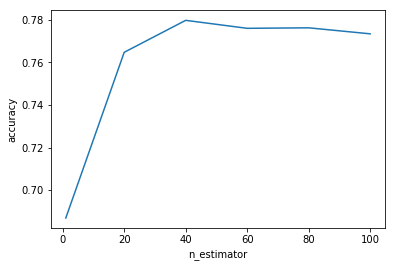

In [61]:
plt.plot(n_estimator_array,mean_acc_array)
plt.xlabel('n_estimator')
plt.ylabel('accuracy')

# SVM implementation

## kernel = Linear

### loading all data

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_decision_regions
%matplotlib inline

#Load data
#y
y = pd.read_csv('y.csv') #load label data
y = y.as_matrix() #convert to numpy array

#X
feat_df = pd.read_csv('data_after_tbp.csv')
X = feat_df.fillna(0) #load feature data and convert NaN to 0
X = X.as_matrix() #convert to numpy array

#id's
ids = pd.read_csv('ids.csv') # load ids 
ids= ids.as_matrix()

In [38]:
#Calculate a K-fold iterator with folds between the users. ( object return indices)
fold_gen = fold_gen_method()

Scaling:

It turns out that the scaling of the features is crucial for the SVM to succeed in training on the data for both accuracy and computation time. 

It matters for computation time because the kernels of SVM's are often dependent on in products of feature vectors. Large feature values will ammount to very large values being multiplied. 

It matters for accuracy because in SVM you try to maximize the distance between the seperator and the support vectors. If some features are much larger they will have a larger impact on the calculated distance and hence on the placing of the seperation line. 

In [39]:
def mean_std_linsvm_acc(fold_gen,X,y,C):
    # Iterate over the K folds and predict a accuracy for every model and calculate the mean preciction
    acc_vector = np.array([])
    for train_idx, test_idx in fold_gen: 
        # Create model
        global svm
        svm = SVC(kernel='linear',C=C, random_state=0)
        # Set local X_train; y_train; X_test; y_test
        scaler = RobustScaler() #scale training data
        global X_train
        X_train = scaler.fit_transform(X[train_idx])
        global y_train
        y_train = y[train_idx]
        global X_test
        X_test = scaler.fit_transform(X[test_idx])
        global y_test
        y_test = y[test_idx]

        # Fit model on train_index
        svm.fit(X_train,y_train)
        # Predict on test_idx
        y_test_pred = svm.predict(X_test)
        # calculate accuracy & append to vector
        acc = accuracy_score(y_true = y_test, y_pred = y_test_pred,normalize = True )
        acc_vector = np.append(acc_vector,acc)
    #Calculate mean accuracy
    mean_acc = np.mean(acc_vector)
    std_dev = np.std(acc_vector)
    return mean_acc,std_dev

In [40]:
mean_acc, std_dev = mean_std_linsvm_acc(fold_gen,X,y,C=1) #36-fold cross validation grouped by users. 
print('The mean accuracy of the model is: ' + str(mean_acc) + ' +/- ' + str(std_dev))

The mean accuracy of the model is: 0.722753996393 +/- 0.112557714223


### Variation of hyperparameter C

c is the inverse of the relaxation factor.

In [61]:
mean_acc_array= np.array([])
c_array = [0.001,0.01,0.1,1,2,3,4]
for c in c_array:
    fold_gen = fold_gen_method()
    mean_acc, std_dev = mean_std_linsvm_acc(fold_gen,X,y,C = c)
    mean_acc_array = np.append(mean_acc_array,mean_acc)
    print(str(mean_acc) +' +/- ' + str(std_dev))

0.718802117341 +/- 0.112499474335
0.711576335419 +/- 0.111891906698
0.711019812892 +/- 0.111415882812
0.722753996393 +/- 0.112557714223
0.723751793466 +/- 0.121128956954
0.720660697227 +/- 0.127198149091
0.719154815163 +/- 0.128437115824
